# Notes


Selenium needs to be installed: pip 
``install requests beautifulsoup4`` 




# Selenium Approach

## Recursive Mention Crawler

When this code is run it opens chrome and ask to log in on twitter, this is required because twitter has too much limitation for guest users.

In [69]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
import time
import re
from collections import defaultdict
import json

# ---------- CONFIGURATION ----------
MAX_DEPTH = 3
MAX_TWEETS = 10
WAIT_TIME = 2

# ---------- UTILITY FUNCTIONS ----------
def extract_mentions(text):
    return re.findall(r"@\w+", text)

# ---------- TWITTER SCRAPER ----------
def login_to_twitter():
    chrome_options = Options()
    chrome_options.add_argument("--start-maximized")
    chrome_options.add_argument("--disable-gpu")
    chrome_options.add_argument("--disable-extensions")
    chrome_options.add_argument("--disable-blink-features=AutomationControlled")

    driver = webdriver.Chrome(options=chrome_options)
    driver.get("https://twitter.com/login")
    print("\n🔐 Please log in manually in the opened browser window.")
    input("✅ Press ENTER after you have successfully logged in...\n")
    return driver

def scrape_mentions(driver, username):
    url = f"https://twitter.com/{username}"
    print(f"Opening: {url}")
    driver.get(url)
    time.sleep(WAIT_TIME)

    # Scroll to load tweets
    last_height = driver.execute_script("return document.body.scrollHeight")
    while len(driver.find_elements(By.XPATH, "//article")) < MAX_TWEETS:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(WAIT_TIME)
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height

    tweets = driver.find_elements(By.XPATH, "//article")[:MAX_TWEETS]
    mentions = set()

    print(f"🧪 Found {len(tweets)} tweet articles on @{username}")

    for i, tweet in enumerate(tweets):
        spans = tweet.find_elements(By.XPATH, ".//span")
        text = " ".join(span.text for span in spans if span.text.strip())
        print(f"🔹 Tweet #{i+1} content: {text}")
        found = extract_mentions(text)
        if found:
            print(f"    ↳ Mentions: {found}")
        mentions.update(found)

    return list(mentions)


# ---------- RECURSIVE CRAWLER ----------
def crawl_mentions_network(start_user):
    driver = login_to_twitter()
    visited = set()
    edges = []

    def dfs(user, depth):
        if depth > MAX_DEPTH or user in visited:
            return
        visited.add(user)
        try:
            mentions = scrape_mentions(driver, user)
        except Exception as e:
            print(f"❌ Failed to scrape @{user}: {e}")
            return

        for mentioned in mentions:
            mentioned_user = mentioned[1:]  # Remove '@'
            edges.append((user, mentioned_user))
            dfs(mentioned_user, depth + 1)
    
    dfs(start_user, 0)
    driver.quit()
    return edges

# ---------- MAIN ----------
if __name__ == "__main__":
    start_username = "wgpaulo"  # Replace with your starting point
    mention_edges = crawl_mentions_network(start_username)

    # Save JSON
    json_name = f"{start_username}_{MAX_DEPTH}_{MAX_TWEETS}.json"
    json_path = os.path.join("mention_networks", json_name)
    
    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(mention_edges, f, indent=2)
    
    print(f"\n✅ Saved mention graph to {json_path}")

    print("\n📈 Mention Edges:")
    for source, target in mention_edges:
        print(f"{source} -> {target}")


Cache folder (C:\Users\paulo\.cache\selenium) cannot be created: Cannot create a file when that file already exists. (os error 183)
Cache folder (C:\Users\paulo\.cache\selenium) cannot be created: Cannot create a file when that file already exists. (os error 183)
Cache folder (C:\Users\paulo\.cache\selenium) cannot be created: Cannot create a file when that file already exists. (os error 183)



🔐 Please log in manually in the opened browser window.


✅ Press ENTER after you have successfully logged in...
 


Opening: https://twitter.com/wgpaulo
🧪 Found 10 tweet articles on @wgpaulo
🔹 Tweet #1 content: You reposted IndiePump IndiePump @IndiePumpCom · It's  #ScreenshotSaturday Time to share your  #indiegame  in the comments below  Have a nice weekend with much  #gaming  Like |   Retweet |   Follow the Bee #IndieGames #IndieDev #GameDev #IndieDevs #GameDeveloper #IndieGameDev #IndieDeveloper #Gamer #IndiePump 53 53 53 24 24 24 70 70 70
    ↳ Mentions: ['@IndiePumpCom']
🔹 Tweet #2 content: You reposted Moons Of Darsalon Moons Of Darsalon @DrKuchoGames · APRIL 6, 2023 BABY!
LET'S GOOOOOOWWW!!!

DO NOT RT THIS if you think it should not be RTed #screenshotsaturday WISHLIST-> http:// DISCORD->  https:// #gamedev #indiedev #indiegame #IndieGameDev #pixelart 3 3 3 62 62 62 203 203 203
    ↳ Mentions: ['@DrKuchoGames']
🔹 Tweet #3 content: You reposted SoyVixterDev SoyVixterDev @SoyVixterDev · Finally published the game! Check out the new update and this new Promo Video to celebrate the release! http

# Visualization of the Graph

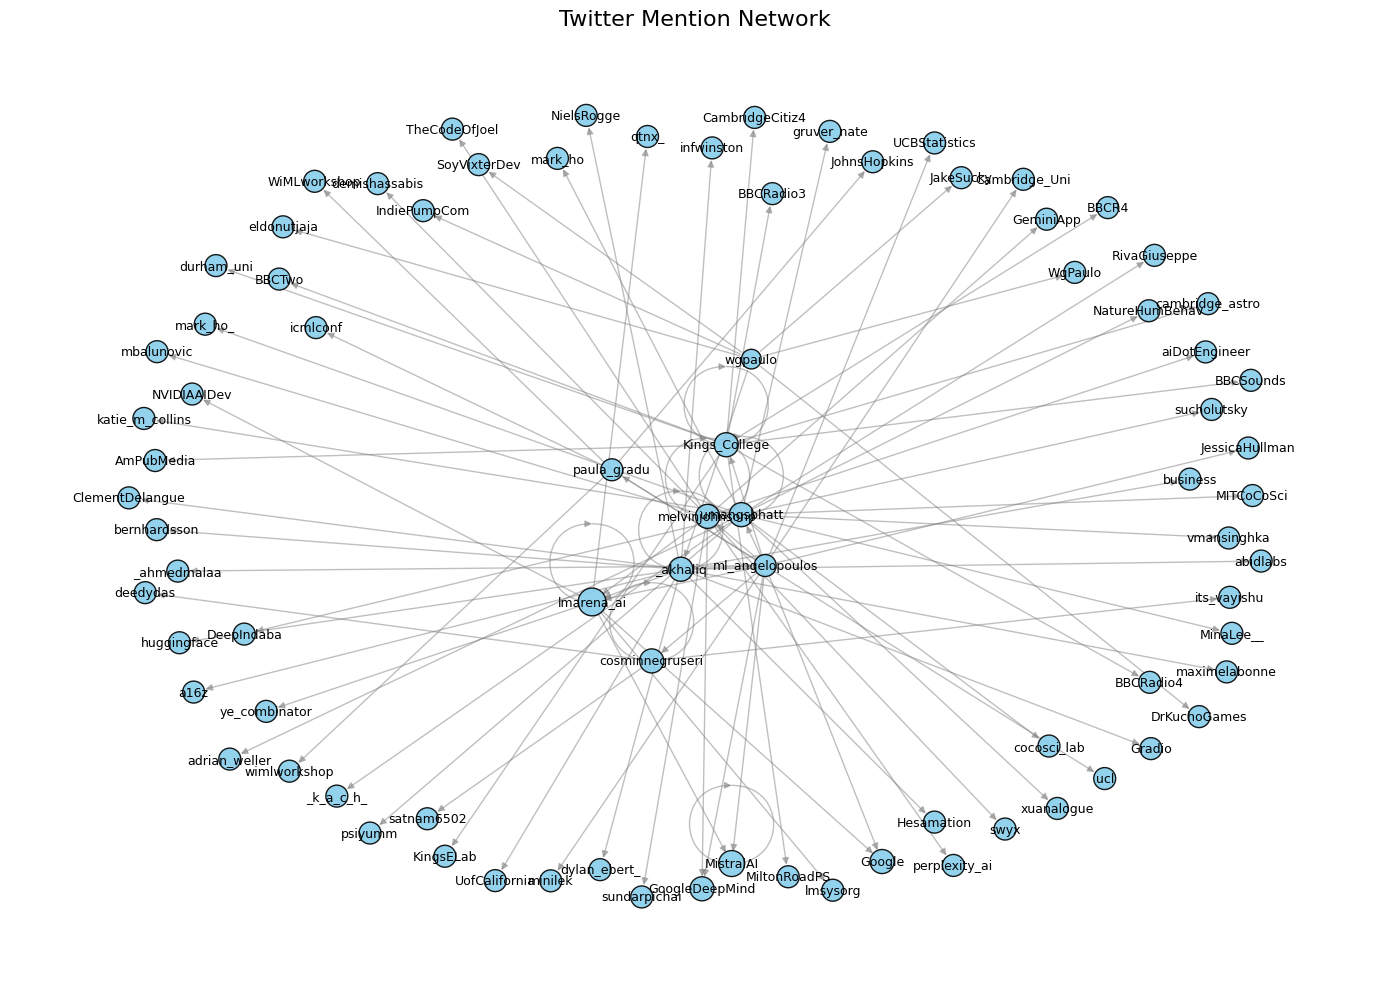

In [70]:
import json
import networkx as nx
import matplotlib.pyplot as plt
import os

# ---------- CONFIGURATION ----------
json_file = "mention_networks/wgpaulo_3_10.json"

# ---------- LOAD JSON ----------
if not os.path.exists(json_file):
    raise FileNotFoundError(f"❌ JSON file not found: {json_file}")

with open(json_file, "r", encoding="utf-8") as f:
    edges = json.load(f)

# ---------- BUILD GRAPH ----------
G = nx.DiGraph()
G.add_edges_from(edges)

# Node size based on in-degree (times mentioned)
mention_counts = dict(G.in_degree())
node_sizes = [200 + 50 * mention_counts.get(node, 0) for node in G.nodes()]

# ---------- DRAW GRAPH ----------
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.5, seed=42)

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="skyblue", alpha=0.9, edgecolors="black")
nx.draw_networkx_edges(G, pos, edge_color="gray", arrows=True, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=9, font_family="sans-serif")

plt.title("Twitter Mention Network", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()


# Depth Hihglighted

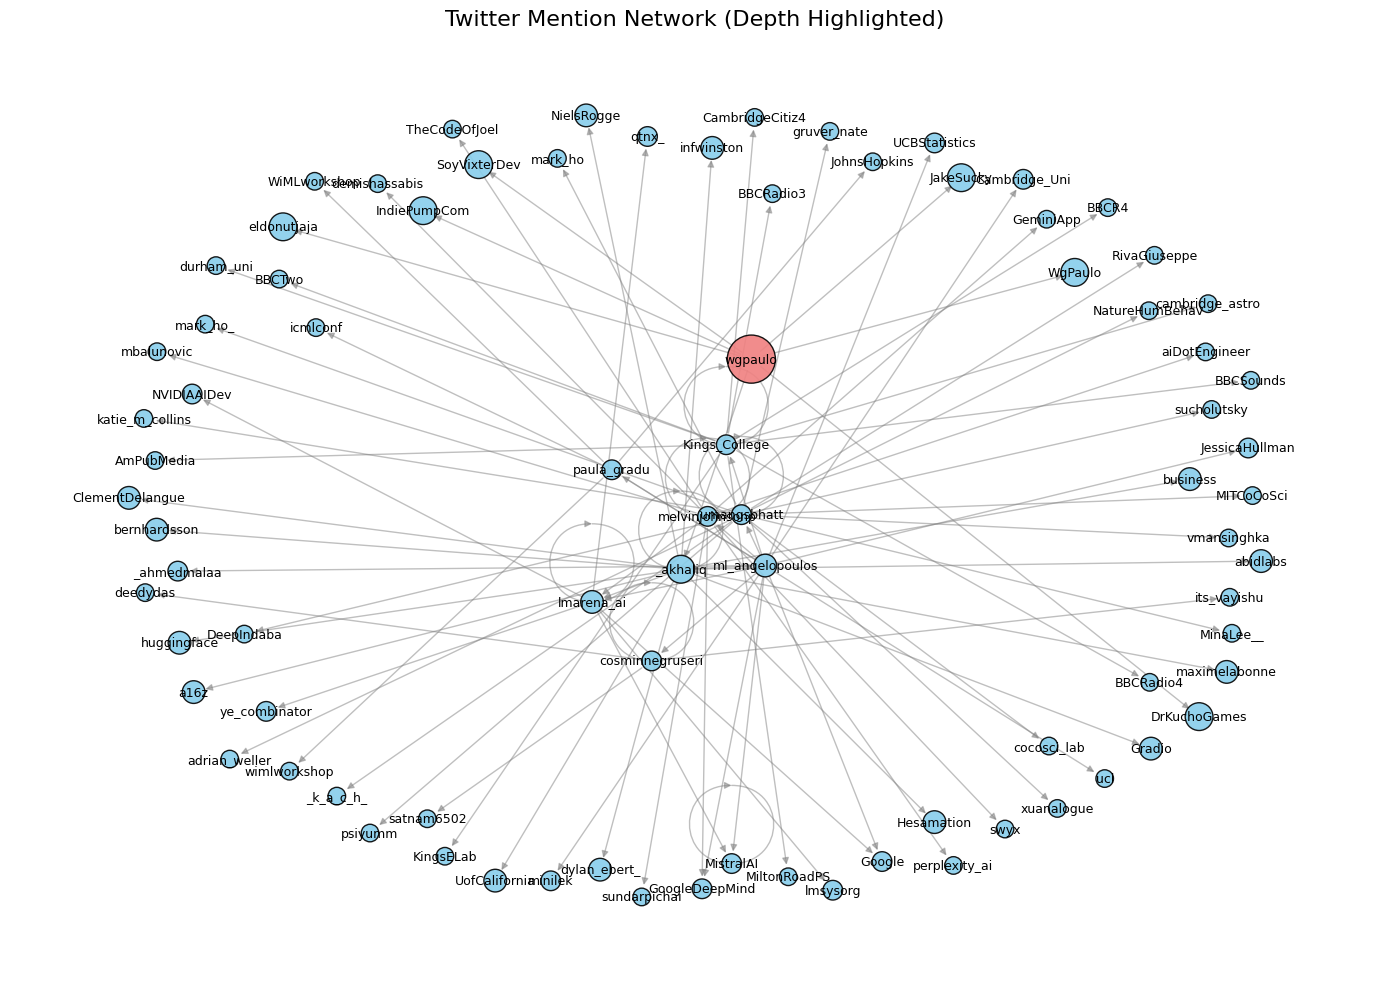

In [71]:
import json
import networkx as nx
import matplotlib.pyplot as plt
import os

# ---------- CONFIGURATION ----------
json_file = "mention_networks/wgpaulo_3_10.json"
start_user = "wgpaulo"  # Starting node to highlight

# ---------- LOAD JSON ----------
if not os.path.exists(json_file):
    raise FileNotFoundError(f"❌ JSON file not found: {json_file}")

with open(json_file, "r", encoding="utf-8") as f:
    edges = json.load(f)

# ---------- BUILD GRAPH ----------
G = nx.DiGraph()
G.add_edges_from(edges)

# Compute shortest path length from start_user
depths = dict(nx.single_source_shortest_path_length(G, start_user))

# Node size based on depth (closer = bigger)
max_depth = max(depths.values()) if depths else 1
node_sizes = []
node_colors = []
for node in G.nodes():
    if node == start_user:
        node_sizes.append(1200)
        node_colors.append("lightcoral")  # Highlight starting node
    else:
        depth = depths.get(node, max_depth + 1)
        size = 800 / (depth + 1)
        node_sizes.append(size)
        node_colors.append("skyblue")

# ---------- DRAW GRAPH ----------
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.5, seed=42)

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.9, edgecolors="black")
nx.draw_networkx_edges(G, pos, edge_color="gray", arrows=True, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=9, font_family="sans-serif")

plt.title("Twitter Mention Network (Depth Highlighted)", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()